In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import pandas as pd

In [2]:
data = pd.read_csv("../data/IT_MA_TBAG50L80_original_data_v0.3.csv")

In [3]:
data.head(1)

,Company Name,Inc Year,Delete Flag,Acquisition Flag,2000-Free Cash Flow Return,2001-Free Cash Flow Return,2002-Free Cash Flow Return,2003-Free Cash Flow Return,2004-Free Cash Flow Return,2005-Free Cash Flow Return,...,2012-Log Sales,2013-Log Sales,2014-Log Sales,2015-Log Sales,2016-Log Sales,2017-Log Sales,2018-Log Sales,2019-Log Sales,2020-Log Sales,2021-Log Sales
0,3D P L M Global Services Pvt. Ltd.,2014.0,TBAG50L80,No,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.098612,5.871836,6.371954,6.536112,6.835722,7.10808,7.197435,7.197435


In [4]:
Y_column  = "Acquisition Flag"
#non_data_cols = ['Acquired','Year of acquisition']
non_data_cols = ['Acquisition Flag','Delete Flag', 'Inc Year','Company Name']

In [5]:
print(f"Total companies : {data.shape[0]}")
print(f"Companies that have all data for all years : {data.dropna().shape[0]}")

Total companies : 125
Companies that have all data for all years : 37


In [6]:
print(f"Total Acquired companies in the dataset : {data[data[Y_column]=='Yes'].shape[0]}")

Total Acquired companies in the dataset : 42


In [7]:
year_count = {}
year_cols = {}
cols = data.columns
for year in range(2000, 2022):
    year_count[f"{year}-"] = 0
    year_cols[f"{year}-"] = []
    for col in data.columns:
        if f"{year}-" in col:
            year_count[f"{year}-"] +=1
            year_cols[f"{year}-"].append(col)

print(year_count)

{'2000-': 17, '2001-': 17, '2002-': 17, '2003-': 17, '2004-': 17, '2005-': 17, '2006-': 17, '2007-': 17, '2008-': 17, '2009-': 17, '2010-': 17, '2011-': 17, '2012-': 17, '2013-': 17, '2014-': 17, '2015-': 17, '2016-': 17, '2017-': 17, '2018-': 17, '2019-': 17, '2020-': 17, '2021-': 17}


In [8]:
dims = year_cols["2015-"]
dims = [dim.replace("2015-","") for dim in dims]
dims

['Free Cash Flow Return',
 'Current ratio (times)',
 'Sales Growth Over Past Year',
 'Quick ratio (times)',
 'Return on total assets',
 'Debt to equity ratio (times)',
 'Debt to Asset ratio',
 'Return on capital employed',
 'Interest Coverage Ratio',
 'Net profit margin',
 'Invested Capital Turnover',
 'Return on equity',
 'Equity turnover',
 'Pre Tax Margin',
 'Return on sales',
 'Log Total assets',
 'Log Sales']

In [9]:
selected_dims = dims

In [10]:
df_ma = data[data[Y_column]=='Yes']
df_ma.shape

(42, 378)

In [11]:
row_null = df_ma.isnull().sum(axis=1).tolist()
df_ma['null_count'] = row_null
print(df_ma[df_ma['null_count']==0].shape)
dfma = df_ma[df_ma['null_count']<200]
print(dfma.shape)

(15, 379)
(42, 379)


/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_1491/3057075647.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ma['null_count'] = row_null


In [12]:
# Not Acquired
df_non_ma = data[data[Y_column]=='No']
print(df_non_ma.shape)
row_null = df_non_ma.isnull().sum(axis=1).tolist()
df_non_ma['null_count'] = row_null
dfnonma = df_non_ma[df_non_ma['null_count']<200]
print(dfnonma.shape)

(83, 378)
(82, 379)


/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_1491/2648874179.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_ma['null_count'] = row_null


In [13]:
dfnonma.shape

(82, 379)

In [14]:
dfma.shape

(42, 379)

In [15]:
df = pd.concat([dfnonma, dfma])
df = df.sort_values(['Company Name']).reset_index(drop=True)
df.head(1)
#df.to_csv("RF_Train_Test_var10.csv")

,Company Name,Inc Year,Delete Flag,Acquisition Flag,2000-Free Cash Flow Return,2001-Free Cash Flow Return,2002-Free Cash Flow Return,2003-Free Cash Flow Return,2004-Free Cash Flow Return,2005-Free Cash Flow Return,...,2013-Log Sales,2014-Log Sales,2015-Log Sales,2016-Log Sales,2017-Log Sales,2018-Log Sales,2019-Log Sales,2020-Log Sales,2021-Log Sales,null_count
0,3I Infotech Consultancy Services Ltd.,2007.0,TBAG50L80,No,NaN,NaN,NaN,NaN,NaN,NaN,...,6.425841,6.407375,6.464744,6.231269,5.855072,6.204558,6.383507,6.445402,6.445402,137


In [16]:
def count_above_mean(x):
    """
    Returns the number of values in x that are higher than the mean of x

    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    m = np.mean(x)
    return np.where(x > m)[0].size

def count_below_mean(x):
    """
    Returns the number of values in x that are lower than the mean of x

    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    m = np.mean(x)
    return np.where(x < m)[0].size

def last_location_of_maximum(x):
    """
    Returns the relative last location of the maximum value of x.
    The position is calculated relatively to the length of x.

    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    x = np.asarray(x)
    return 1.0 - np.argmax(x[::-1]) / len(x) if len(x) > 0 else np.NaN

def first_location_of_maximum(x):
    """
    Returns the first location of the maximum value of x.
    The position is calculated relatively to the length of x.

    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    if not isinstance(x, (np.ndarray, pd.Series)):
        x = np.asarray(x)
    return np.argmax(x) / len(x) if len(x) > 0 else np.NaN

In [17]:
# Feature Extraction
features_df = pd.DataFrame()
for dim in selected_dims:
    cols = [f"{str(year)}-{dim}" for year in range(2000, 2022)]
    df_dim = df[cols]
    df_dim = df_dim.astype(float)
    features_df[f"{dim}__max"] = df_dim.max(axis=1)
    features_df[f"{dim}__min"] = df_dim.min(axis=1)
    features_df[f"{dim}__variance"] = df_dim.var(axis=1)
    features_df[f"{dim}__std"] = df_dim.std(axis=1)
    features_df[f"{dim}__sum"] = df_dim.sum(axis=1)
    features_df[f"{dim}__mean"] = df_dim.mean(axis=1)
    features_df[f"{dim}__skew"] = df_dim.skew(axis=1)
    features_df[f"{dim}__kurtosis"] = df_dim.kurtosis(axis=1)
    features_df[f"{dim}__cnt_above_mean"] = df_dim.apply(count_above_mean, axis=1)
    features_df[f"{dim}__cnt_below_mean"] = df_dim.apply(count_below_mean, axis=1)
    #features_df[f"{dim}__first_max"] = df_dim.apply(first_location_of_maximum, axis=1)
    #features_df[f"{dim}__last_max"] = df_dim.apply(last_location_of_maximum, axis=1)

features_df[Y_column] = pd.Categorical(df[Y_column]).codes

/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_1491/500522213.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[f"{dim}__max"] = df_dim.max(axis=1)
/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_1491/500522213.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[f"{dim}__min"] = df_dim.min(axis=1)
/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_1491/500522213.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_1491/500522213.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[f"{dim}__max"] = df_dim.max(axis=1)
/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_1491/500522213.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[f"{dim}__min"] = df_dim.min(axis=1)
/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_1491/500522213.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

In [18]:
features_df = features_df.apply(lambda x: x.fillna(x.mean()), axis=0)
features_df = features_df.dropna()
features_df

,Free Cash Flow Return__max,Free Cash Flow Return__min,Free Cash Flow Return__variance,Free Cash Flow Return__std,Free Cash Flow Return__sum,Free Cash Flow Return__mean,Free Cash Flow Return__skew,Free Cash Flow Return__kurtosis,Free Cash Flow Return__cnt_above_mean,Free Cash Flow Return__cnt_below_mean,...,Log Sales__min,Log Sales__variance,Log Sales__std,Log Sales__sum,Log Sales__mean,Log Sales__skew,Log Sales__kurtosis,Log Sales__cnt_above_mean,Log Sales__cnt_below_mean,Acquisition Flag
0,0.30,-0.57,0.037422,0.193448,-0.380,-0.027143,-1.600567,4.912798,11,3,...,5.751302,0.072254,0.268800,88.754139,6.339581,-0.992303,1.225048,9,5,0
1,0.15,-0.02,0.002916,0.054002,1.090,0.051905,0.591858,-0.829627,8,13,...,7.291111,0.162001,0.402494,168.019378,8.000923,0.054206,-1.161207,10,11,1
2,0.41,-0.13,0.016498,0.128445,1.350,0.061364,0.793360,1.448517,11,11,...,3.988984,1.139456,1.067453,129.367115,5.880323,-0.788536,-1.012186,14,8,0
3,0.38,-0.11,0.009832,0.099158,1.610,0.073182,1.354751,3.599323,9,13,...,4.023564,0.779859,0.883097,134.066680,6.093940,-1.021509,0.185407,13,9,0
4,0.17,-0.02,0.003612,0.060102,0.635,0.030238,1.832624,2.019822,5,16,...,-0.693147,0.816670,0.903698,20.108514,0.957548,-0.310320,-0.266889,13,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,0.29,-0.12,0.009828,0.099136,1.485,0.067500,0.123445,0.004111,12,10,...,3.370738,1.457778,1.207385,116.990656,5.317757,-0.259344,-1.606657,11,11,0
120,1.20,-2.53,0.376235,0.613380,-1.720,-0.078182,-2.861555,13.908508,18,4,...,-1.203973,5.390034,2.321645,36.264569,1.648390,0.520185,-1.082950,11,11,1
121,0.30,-0.28,0.013914,0.117956,2.250,0.102273,-1.383234,4.531897,13,9,...,3.749504,1.298179,1.139377,132.729115,6.033142,-0.645616,-0.427236,11,11,0
122,1.42,-0.20,0.114992,0.339105,1.790,0.094211,3.634300,14.667534,3,16,...,6.018593,0.395275,0.628709,132.197075,6.957741,-0.391083,-1.357491,11,8,1


In [19]:
X = features_df.drop(columns=[Y_column])
X_train, X_test, y_train, y_test = train_test_split(X, features_df[Y_column], random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(93, 170) (31, 170) (93,) (31,)


In [20]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7419354838709677

In [21]:
feature_importances = {}
for feature, value in zip(features_df.columns, rf.feature_importances_):
    feature = feature.split("__")[0]
    if feature in feature_importances:
        val_list = feature_importances[feature]
    else:
        val_list = []
    val_list.append(np.round(value,4))
    feature_importances[feature] = val_list

In [22]:
for key in feature_importances.keys():
    print(key, np.sum(feature_importances[key]))

Free Cash Flow Return 0.0582
Current ratio (times) 0.06490000000000001
Sales Growth Over Past Year 0.0557
Quick ratio (times) 0.07559999999999999
Return on total assets 0.041800000000000004
Debt to equity ratio (times) 0.045899999999999996
Debt to Asset ratio 0.0467
Return on capital employed 0.04370000000000001
Interest Coverage Ratio 0.06899999999999999
Net profit margin 0.0451
Invested Capital Turnover 0.06620000000000001
Return on equity 0.0577
Equity turnover 0.0779
Pre Tax Margin 0.0364
Return on sales 0.0726
Log Total assets 0.059899999999999995
Log Sales 0.0828


In [23]:
test_probs = rf.predict_proba(X_test)
y_pred = rf.predict(X_test)
for prob, pred, actual in zip(test_probs, y_pred, y_test):
    print(prob, pred, actual)

[0.78 0.22] 0 0
[0.63 0.37] 0 0
[0.62 0.38] 0 0
[0.61 0.39] 0 0
[0.63 0.37] 0 0
[0.71 0.29] 0 0
[0.88 0.12] 0 0
[0.48 0.52] 1 1
[0.64 0.36] 0 0
[0.92 0.08] 0 0
[0.9 0.1] 0 1
[0.62 0.38] 0 0
[0.66 0.34] 0 1
[0.67 0.33] 0 1
[0.43 0.57] 1 1
[0.63 0.37] 0 0
[0.29 0.71] 1 0
[0.36 0.64] 1 1
[0.58 0.42] 0 0
[0.79 0.21] 0 0
[0.62 0.38] 0 0
[0.36 0.64] 1 0
[0.72 0.28] 0 0
[0.49 0.51] 1 1
[0.37 0.63] 1 1
[0.69 0.31] 0 0
[0.64 0.36] 0 1
[0.56 0.44] 0 1
[0.69 0.31] 0 0
[0.8 0.2] 0 0
[0.48 0.52] 1 0


In [24]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(y_test, y_pred)

array([[18,  3],
       [ 5,  5]])

/Users/venuraja/pyenvs/general_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


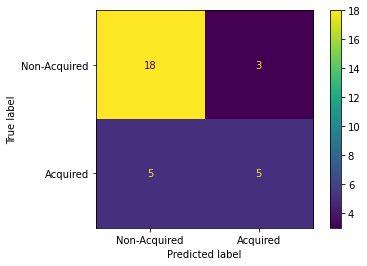

In [25]:
plot_confusion_matrix(rf, X_test, y_test, display_labels=['Non-Acquired','Acquired'])

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(f"Precision : {precision_score(y_test, y_pred)}")
print(f"Recall : {recall_score(y_test, y_pred)}")
print(f"F1 : {f1_score(y_test, y_pred)}")
print(f"Accuracy : {accuracy_score(y_test, y_pred)}")

Precision : 0.625
Recall : 0.5
F1 : 0.5555555555555556
Accuracy : 0.7419354838709677


In [27]:
import matplotlib.pyplot as plt
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,7), dpi=1000)
tree.plot_tree(rf.estimators_[5],
               feature_names = features_df.columns, 
               class_names=["Non Acquired","Acquired"],
               max_depth=2,
               fontsize=7,
               filled = True);